# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### read the data"

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
pd.set_option('display.max_columns',99)
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### cleaning portfolio Dataframe

In [6]:
e = 'email'
portfolio['email'] = ''
w = 'web'
portfolio['web'] = ''
m = 'mobile'
portfolio['mobile'] = ''
s = 'social'
portfolio['social'] = ''

for i,j in portfolio.iterrows():
    if w in j.channels:
        portfolio.iloc[i , portfolio.columns.get_loc(w)] = 1
    else:
        portfolio.iloc[i , portfolio.columns.get_loc(w)] = 0
        
    if e in j.channels:
        portfolio.iloc[i , portfolio.columns.get_loc(e)] = 1
    else:
        portfolio.iloc[i , portfolio.columns.get_loc(e)] = 0
        
    if m in j.channels:
        portfolio.iloc[i , portfolio.columns.get_loc(m)] = 1
    else:
        portfolio.iloc[i , portfolio.columns.get_loc(m)] = 0
        
    if s in j.channels:
        portfolio.iloc[i , portfolio.columns.get_loc(s)] = 1
    else:
        portfolio.iloc[i , portfolio.columns.get_loc(s)] = 0

In [7]:
portfolio = portfolio.drop(columns=['channels'])

In [8]:
portfolio

,difficulty,duration,id,offer_type,reward,email,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


### cleaning transcript Dataframe

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [11]:
import warnings
warnings.filterwarnings("ignore")

df1 = transcript[transcript.event == 'transaction']
df2 = transcript[transcript.event == 'offer received']
df3 = transcript[transcript.event == 'offer viewed']
df4 = transcript[transcript.event == 'offer completed']
df1['amount'] = df1.value.apply(lambda x:list(x.values())[0])
df2['offer_id'] = df2.value.apply(lambda x:list(x.values())[0])
df3['offer_id'] = df3.value.apply(lambda x:list(x.values())[0])
df4['offer_id'] = df4.value.apply(lambda x:list(x.values())[0])
df4['reward'] = df4.value.apply(lambda x:list(x.values())[1])
transcript = pd.concat([df1,df2,df3,df4])
transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
transcript.drop(columns='value' , inplace=True)

In [12]:
transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


### cleaning profile Dataframe


In [13]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
profile.info()
#gender and income has missing values ,I have to handle this problem.\

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [15]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
# fill the missing value in gender with U that mean unknowon
profile.gender.fillna('U' , inplace=True)

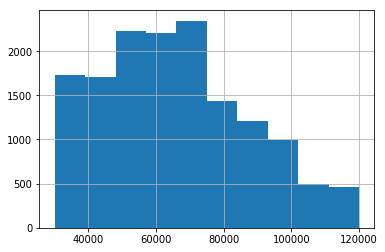

In [18]:
profile.income.hist()

In [19]:
# fill the missing value with the mean value
profile.income.fillna(profile.income.mean() , inplace=True)

In [20]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [21]:
profile.became_member_on = profile.became_member_on.apply(lambda x:str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
profile.became_member_on = pd.to_datetime(profile.became_member_on)

118


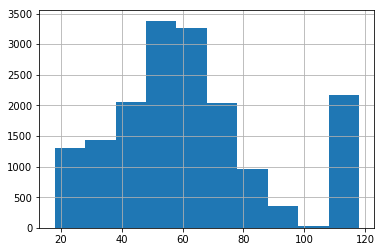

In [22]:
# as you see there is a problem with the ages,I will drop the outlier
profile.age.hist()
print(profile.age.max())

In [23]:
profile = profile[profile.age != profile.age.max()]

In [24]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [25]:
# now lets do some data exploration 

### Data Exploration

In [26]:
def plotTime(df, col, period = 'M'):
    df_period = df.groupby(df[col].dt.to_period(period)).size().rename('freq').reset_index()
    df_period.plot(x= col , y='freq' , figsize=(15,4))

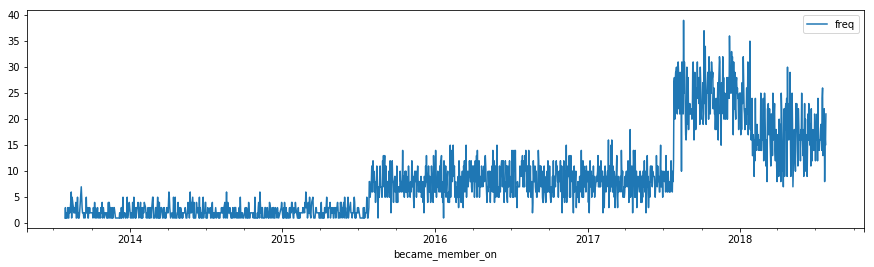

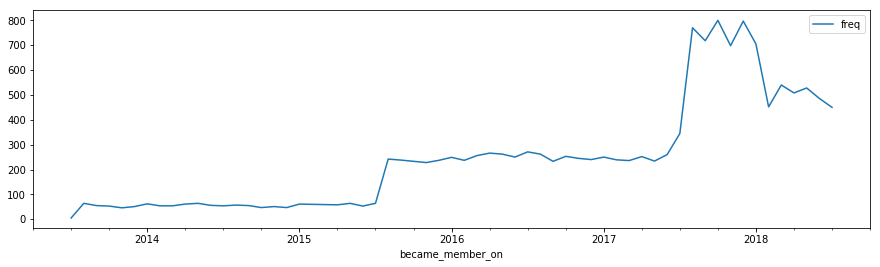

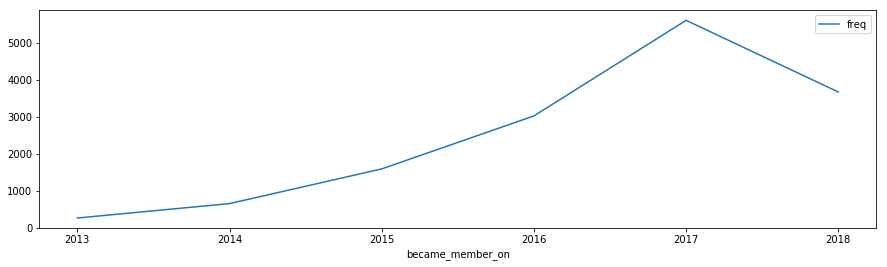

In [27]:
# this is the time series for become_member_on by day , month and year  
plotTime(profile , 'became_member_on'  , 'D')
plotTime(profile , 'became_member_on'  , 'M')
plotTime(profile , 'became_member_on'  , 'Y')

as you can see 2017 has the greatest date when customer created an app account

In [28]:
# in this code I grouped the age as catigory ,
profile['age_group'] = pd.cut(profile.age , bins=[15,24,34,44,54,64 , 74 ,150] , labels=['15-24' ,
                                                                                         '25-34' , 
                                                                                         '35-44' , 
                                                                                         '45-54' , 
                                                                                         '55-64',
                                                                                         '65-74' 
                                                                                         ,'75+'])

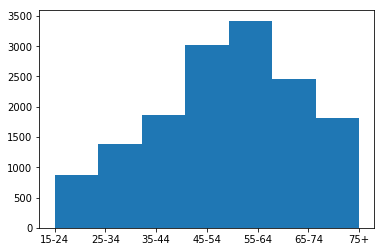

In [29]:
_ = profile.age_group.hist(bins=7 , grid=False)

In [30]:
# lets see the income avr for each age group
age_group_avr_income = profile.groupby('age_group').income.mean().reset_index()

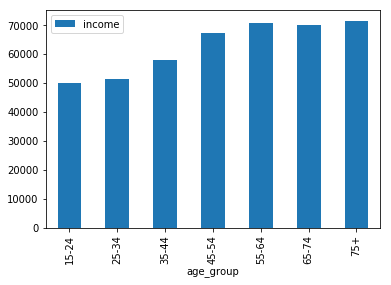

In [31]:
_=age_group_avr_income.plot(x='age_group',kind='bar')

as you see the older person had better income 

In [32]:
# lets see the avg age per gender 

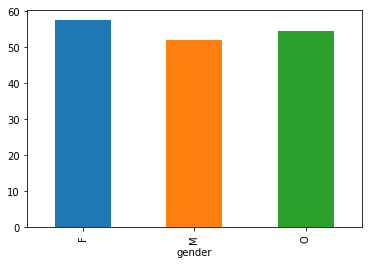

In [33]:
avg_age_per_gender = profile.groupby('gender').age.mean()
_ = avg_age_per_gender.plot(x='gender',kind='bar')

as you can see the Famale had older age

In [34]:
# lets see the avr income per gender

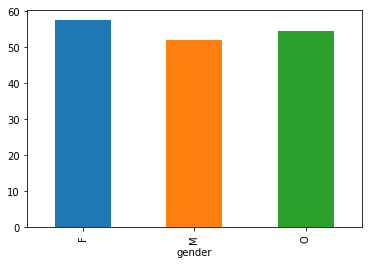

In [35]:
avr_income_per_gender = profile.groupby('gender').income.mean()
_ = avg_age_per_gender.plot(x='gender',kind='bar')

as you can see the Famale had better income

### Data Modeling

In [36]:
# here i will work with transcript table to do one hot encoding for event type 
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')

In [71]:
# here i check the number of duplicated rows
transcript.duplicated().sum()

0

In [38]:
# here i drop the duplicated rows
transcript.drop_duplicates(inplace=True)

In [40]:
# here i mearge the transcript dataframe with profile dataframe
transcript_merged = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
transcript_merged.drop(columns=['id'] , inplace=True)
transcript_merged.reward.fillna(0 , inplace=True)
transcript_merged.amount.fillna(0 , inplace=True)

In [41]:
# here i sort the data by the time
transcript_merged.sort_values(by=['time'] , ascending=True , inplace=True)

# here i do cumsum for transaction and amount to see if i can use it.
mylist = ['transaction', 'amount']

for i in mylist:
    transcript_merged[i] = transcript_merged.groupby('person')[i].cumsum()

In [73]:
transcript_merged.isna().sum()

person              0
offer_id            0
time                0
amount              0
reward_x            0
offer completed     0
offer received      0
offer viewed        0
transaction         0
age                 0
became_member_on    0
gender              0
income              0
age_group           0
difficulty          0
duration            0
id                  0
offer_type          0
reward_y            0
email               0
web                 0
mobile              0
social              0
dtype: int64

In [45]:
# cus I just foucs in offers I drop any row than does not contain offer
transcript_merged.dropna(subset=['offer_id'] ,inplace=True)

In [46]:
# here i merge the data with offers table
transcript_merged = transcript_merged.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')

In [47]:
# here i just select the needed columns with group by person and offer_type
ML_data = transcript_merged.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,    # Sum duration per group
         'offer received': sum,  # get the count of networks
         'offer viewed': sum,  # get the first date per group
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
        
        
    }
).reset_index()

In [48]:
# this function is to tansform the offers
def transform_offers(df):
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
        
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [49]:
transformed_data = transform_offers(ML_data)

In [50]:
transformed_data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3


In [51]:
# here i just do percentage for each offer (bogo and discount)
transformed_data['bogo_percentage'] =  transformed_data.bogo_completed.div(transformed_data.bogo_received.where(transformed_data.bogo_received != 0, np.nan))*100
transformed_data['discount_percentage'] =  transformed_data.discount_completed.div(transformed_data.discount_received.where(transformed_data.discount_received != 0, np.nan))*100

In [52]:
transformed_data.head(10)

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_percentage,discount_percentage
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2,100.0,100.0
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2,100.0,100.0
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2,50.0,100.0
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1,100.0,100.0
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3,NaN,100.0
5,00426fe3ffde4c6b9cb9ad6d077a13ea,19,2016-08-09,F,65000.0,0,0,4,1,NaN,25.0
6,004b041fbfe44859945daa2c7f79ee64,55,2018-05-08,F,74000.0,1,1,1,1,100.0,100.0
7,004c5799adbf42868b9cff0396190900,54,2016-03-31,M,99000.0,3,3,2,2,100.0,100.0
8,005500a7188546ff8a767329a2f7c76a,56,2017-12-09,M,47000.0,4,1,1,0,25.0,0.0
9,0056df74b63b4298809f0b375a304cf4,54,2016-08-21,M,91000.0,1,1,2,2,100.0,100.0


In [53]:
transformed_data.isna().sum()

person                    0
age                       0
became_member_on          0
gender                    0
income                    0
bogo_received             0
bogo_completed            0
discount_received         0
discount_completed        0
bogo_percentage        1738
discount_percentage    1778
dtype: int64

In [54]:
# fill null values with 0 
transformed_data.fillna(0 , inplace=True)

In [55]:
# this code to check if the person will responed to the offer or no
transformed_data['bogo_offer'] = 0
transformed_data['discount_offer'] = 0


for index ,row in transformed_data.iterrows():
    
    if(row['bogo_percentage'] >= 80):
        transformed_data.loc[index , 'bogo_offer'] = 1
        
    if(row['discount_percentage'] >= 80 ):
        transformed_data.loc[index , 'discount_offer'] = 1

        

In [57]:
ML_data1 = transformed_data.copy()

In [58]:
ML_data1['year'] = ML_data1.became_member_on.dt.year
ML_data1['month'] = ML_data1.became_member_on.dt.month

In [59]:
ML_data1 = ML_data1[['age' , 'gender' , 'income' , 'year' , 'month' , 'discount_offer' , 'bogo_offer']]

In [60]:
ML_data1.dtypes

age                 int64
gender             object
income            float64
year                int64
month               int64
discount_offer      int64
bogo_offer          int64
dtype: object

In [61]:
ML_data2 = pd.get_dummies(ML_data1 , columns=['gender'])

### train the model

In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV

In [74]:
X = ML_data2.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = ML_data2.bogo_offer
y_discount = ML_data2.discount_offer

X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)

X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn_bogo = KNeighborsClassifier()
knn_discount = KNeighborsClassifier()
knn_bogo.fit(X_train, y_bogo_train)
knn_discount.fit(X_train, y_discount_train)


print('Training F1_score for  bogo offer is:', knn_bogo.score(X_train,y_discount_train))
print('Test F1_score for bogo offer is:', knn_bogo.score(X_test,y_discount_test))

print('Training F1_score for discount offer is:', knn_discount.score(X_train,y_discount_train))
print('Test F1_score for discount offer is:', knn_discount.score(X_test,y_discount_test))

Training F1_score for  bogo offer is: 0.602249212776
Test F1_score for bogo offer is: 0.545748987854
Training F1_score for discount offer is: 0.714260008997
Test F1_score for discount offer is: 0.543049932524


In [65]:
from sklearn.naive_bayes import GaussianNB
gnb_bogo = GaussianNB()
gnb_discount = GaussianNB()
gnb_bogo.fit(X_train, y_bogo_train)
gnb_discount.fit(X_train, y_discount_train)


print('Training F1_score for bogo offer is:', gnb_bogo.score(X_train,y_discount_train))
print('Test F1_score for bogo offer is:', gnb_bogo.score(X_test,y_discount_test))

print('Training F1_score for discount offer is:', gnb_discount.score(X_train,y_discount_train))
print('Test F1_score for discount offer is:', gnb_discount.score(X_test,y_discount_test))

Training F1_score for bogo offer is: 0.602159244265
Test F1_score for bogo offer is: 0.595141700405
Training F1_score for discount offer is: 0.620962663068
Test F1_score for discount offer is: 0.607287449393


In [66]:
ADA_bogo = AdaBoostClassifier()
ADA_discount = AdaBoostClassifier()

ADA_bogo.fit(X_train, y_bogo_train)
ADA_discount.fit(X_train, y_discount_train)


print('Training F1_score for bogo offer is:', ADA_bogo.score(X_train,y_discount_train))
print('Test F1_score for bogo offer is:', ADA_bogo.score(X_test,y_discount_test))

print('Training F1_score for discount offer is:', ADA_discount.score(X_train,y_discount_train))
print('Test F1_score for discount offer is:', ADA_discount.score(X_test,y_discount_test))

Training F1_score for bogo offer is: 0.637966711651
Test F1_score for bogo offer is: 0.641295546559
Training F1_score for discount offer is: 0.656140350877
Test F1_score for discount offer is: 0.651012145749


In [67]:
def predict(person , offer):
    pred_bogo = 0
    pred_discount = 0 
    

    pred_bogo = ADA_bogo.predict(person.values)[0]
    pred_discount = ADA_discount.predict(person.values)[0]
    
    if(pred_bogo == 0 & pred_discount == 0):
        print('Not Respond!')

        
    if (offer == 'bogo'):
        if(pred_bogo == 0):
            if(pred_discount == 1):
                print('The person preferred discount than bogo')           
        else:
            print('Bogo will be a good choice :)')
    if (offer == 'discount'):
        if(pred_discount == 0):
            if(pred_bogo == 1):
                print('The person preferred bogo than discount')           
        else:
            print('Discount will be a good choice :)')


In [75]:
predict(X_test[1:2] ,'bogo')

bogo will be a good choice :)


In [76]:
predict(X_test[0:1] ,'bogo')

Not Respond!


In [70]:
predict(X_test[1745:1746] , 'discount')

the person preferred bogo than discount


### Conclusion
this notebook contains five section:
- read the data
- clean the data
- Data Exploration
- data modeling
- train the model 

I create a Machine learning model that predict the offer will be Respond by the person or no, if yes the model will choose the best offer type (discount or bogo).